# Demo Deep Belief Network para para clasificar (atributo clase discreto) o estimar (atributo clase continuo)
  Nota: se usan modelos copiados de https://github.com/albertbup/deep-belief-network porque falla al intentar instalarlos

In [1]:
#@title Librerías a usar

# nota se debe indicar la versión 1 de TF para compatibilidad del código
import tensorflow as tf

import numpy as np
import pandas as pd
import math
from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt

import os
import csv

import ipywidgets as widgets
from ipywidgets import Box, Layout
from IPython.display import clear_output

print ("Librerías cargadas.")

Librerías cargadas.


In [2]:
#@title Clases copiadas de https://github.com/albertbup/deep-belief-network 

from abc import ABCMeta, abstractmethod

import numpy as np
from scipy.stats import truncnorm
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin, RegressorMixin


def batch_generator(batch_size, data, labels=None):
    """
    Generates batches of samples
    :param data: array-like, shape = (n_samples, n_features)
    :param labels: array-like, shape = (n_samples, )
    :return:
    """
    n_batches = int(np.ceil(len(data) / float(batch_size)))
    idx = np.random.permutation(len(data))
    data_shuffled = data[idx]
    if labels is not None:
        labels_shuffled = labels[idx]
    for i in range(n_batches):
        start = i * batch_size
        end = start + batch_size
        if labels is not None:
            yield data_shuffled[start:end, :], labels_shuffled[start:end]
        else:
            yield data_shuffled[start:end, :]


def to_categorical(labels, num_classes):
    """
    Converts labels as single integer to row vectors. For instance, given a three class problem, labels would be
    mapped as label_1: [1 0 0], label_2: [0 1 0], label_3: [0, 0, 1] where labels can be either int or string.
    :param labels: array-like, shape = (n_samples, )
    :return:
    """
    new_labels = np.zeros([len(labels), num_classes])
    label_to_idx_map, idx_to_label_map = dict(), dict()
    idx = 0
    for i, label in enumerate(labels):
        if label not in label_to_idx_map:
            label_to_idx_map[label] = idx
            idx_to_label_map[idx] = label
            idx += 1
        new_labels[i][label_to_idx_map[label]] = 1
    return new_labels, label_to_idx_map, idx_to_label_map

class ActivationFunction(object):
    """
    Class for abstract activation function.
    """
    __metaclass__ = ABCMeta

    @abstractmethod
    def function(self, x):
        return

    @abstractmethod
    def prime(self, x):
        return


class SigmoidActivationFunction(ActivationFunction):
    @classmethod
    def function(cls, x):
        """
        Sigmoid function.
        :param x: array-like, shape = (n_features, )
        :return:
        """
        return 1 / (1.0 + np.exp(-x))

    @classmethod
    def prime(cls, x):
        """
        Compute sigmoid first derivative.
        :param x: array-like, shape = (n_features, )
        :return:
        """
        return x * (1 - x)


class ReLUActivationFunction(ActivationFunction):
    @classmethod
    def function(cls, x):
        """
        Rectified linear function.
        :param x: array-like, shape = (n_features, )
        :return:
        """
        return np.maximum(np.zeros(x.shape), x)

    @classmethod
    def prime(cls, x):
        """
        Rectified linear first derivative.
        :param x: array-like, shape = (n_features, )
        :return:
        """
        return (x > 0).astype(int)


class TanhActivationFunction(ActivationFunction):
    @classmethod
    def function(cls, x):
        """
        Hyperbolic tangent function.
        :param x: array-like, shape = (n_features, )
        :return:
        """
        return np.tanh(x)

    @classmethod
    def prime(cls, x):
        """
        Hyperbolic tangent first derivative.
        :param x: array-like, shape = (n_features, )
        :return:
        """
        return 1 - x * x


class BaseModel(object):
    def save(self, save_path):
        import pickle

        with open(save_path, 'wb') as fp:
            pickle.dump(self, fp)

    @classmethod
    def load(cls, load_path):
        import pickle

        with open(load_path, 'rb') as fp:
            return pickle.load(fp)


class BinaryRBM(BaseEstimator, TransformerMixin, BaseModel):
    """
    This class implements a Binary Restricted Boltzmann machine.
    """

    def __init__(self,
                 n_hidden_units=100,
                 activation_function='sigmoid',
                 optimization_algorithm='sgd',
                 learning_rate=1e-3,
                 n_epochs=10,
                 contrastive_divergence_iter=1,
                 batch_size=500,
                 verbose=True):
        self.n_hidden_units = n_hidden_units
        self.activation_function = activation_function
        self.optimization_algorithm = optimization_algorithm
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.contrastive_divergence_iter = contrastive_divergence_iter
        self.batch_size = batch_size
        self.verbose = verbose

    def fit(self, X):
        """
        Fit a model given data.
        :param X: array-like, shape = (n_samples, n_features)
        :return:
        """
        # Initialize RBM parameters
        self.n_visible_units = X.shape[1]
        if self.activation_function == 'sigmoid':
            self.W = np.random.randn(self.n_hidden_units, self.n_visible_units) / np.sqrt(self.n_visible_units)
            self.c = np.random.randn(self.n_hidden_units) / np.sqrt(self.n_visible_units)
            self.b = np.random.randn(self.n_visible_units) / np.sqrt(self.n_visible_units)
            self._activation_function_class = SigmoidActivationFunction
        elif self.activation_function == 'relu':
            self.W = truncnorm.rvs(-0.2, 0.2, size=[self.n_hidden_units, self.n_visible_units]) / np.sqrt(
                self.n_visible_units)
            self.c = np.full(self.n_hidden_units, 0.1) / np.sqrt(self.n_visible_units)
            self.b = np.full(self.n_visible_units, 0.1) / np.sqrt(self.n_visible_units)
            self._activation_function_class = ReLUActivationFunction
        else:
            raise ValueError("Invalid activation function.")

        if self.optimization_algorithm == 'sgd':
            self._stochastic_gradient_descent(X)
        else:
            raise ValueError("Invalid optimization algorithm.")
        return self

    def transform(self, X):
        """
        Transforms data using the fitted model.
        :param X: array-like, shape = (n_samples, n_features)
        :return:
        """
        if len(X.shape) == 1:  # It is a single sample
            return self._compute_hidden_units(X)
        transformed_data = self._compute_hidden_units_matrix(X)
        return transformed_data

    def _reconstruct(self, transformed_data):
        """
        Reconstruct visible units given the hidden layer output.
        :param transformed_data: array-like, shape = (n_samples, n_features)
        :return:
        """
        return self._compute_visible_units_matrix(transformed_data)

    def _stochastic_gradient_descent(self, _data):
        """
        Performs stochastic gradient descend optimization algorithm.
        :param _data: array-like, shape = (n_samples, n_features)
        :return:
        """
        accum_delta_W = np.zeros(self.W.shape)
        accum_delta_b = np.zeros(self.b.shape)
        accum_delta_c = np.zeros(self.c.shape)
        for iteration in range(1, self.n_epochs + 1):
            idx = np.random.permutation(len(_data))
            data = _data[idx]
            for batch in batch_generator(self.batch_size, data):
                accum_delta_W[:] = .0
                accum_delta_b[:] = .0
                accum_delta_c[:] = .0
                for sample in batch:
                    delta_W, delta_b, delta_c = self._contrastive_divergence(sample)
                    accum_delta_W += delta_W
                    accum_delta_b += delta_b
                    accum_delta_c += delta_c
                self.W += self.learning_rate * (accum_delta_W / self.batch_size)
                self.b += self.learning_rate * (accum_delta_b / self.batch_size)
                self.c += self.learning_rate * (accum_delta_c / self.batch_size)
            if self.verbose:
                error = self._compute_reconstruction_error(data)
                print(">> Epoch %d finished \tRBM Reconstruction error %f" % (iteration, error))

    def _contrastive_divergence(self, vector_visible_units):
        """
        Computes gradients using Contrastive Divergence method.
        :param vector_visible_units: array-like, shape = (n_features, )
        :return:
        """
        v_0 = vector_visible_units
        v_t = np.array(v_0)

        # Sampling
        for t in range(self.contrastive_divergence_iter):
            h_t = self._sample_hidden_units(v_t)
            v_t = self._compute_visible_units(h_t)

        # Computing deltas
        v_k = v_t
        h_0 = self._compute_hidden_units(v_0)
        h_k = self._compute_hidden_units(v_k)
        delta_W = np.outer(h_0, v_0) - np.outer(h_k, v_k)
        delta_b = v_0 - v_k
        delta_c = h_0 - h_k

        return delta_W, delta_b, delta_c

    def _sample_hidden_units(self, vector_visible_units):
        """
        Computes hidden unit activations by sampling from a binomial distribution.
        :param vector_visible_units: array-like, shape = (n_features, )
        :return:
        """
        hidden_units = self._compute_hidden_units(vector_visible_units)
        return (np.random.random_sample(len(hidden_units)) < hidden_units).astype(np.int64)

    def _sample_visible_units(self, vector_hidden_units):
        """
        Computes visible unit activations by sampling from a binomial distribution.
        :param vector_hidden_units: array-like, shape = (n_features, )
        :return:
        """
        visible_units = self._compute_visible_units(vector_hidden_units)
        return (np.random.random_sample(len(visible_units)) < visible_units).astype(np.int64)

    def _compute_hidden_units(self, vector_visible_units):
        """
        Computes hidden unit outputs.
        :param vector_visible_units: array-like, shape = (n_features, )
        :return:
        """
        v = np.expand_dims(vector_visible_units, 0)
        h = np.squeeze(self._compute_hidden_units_matrix(v))
        return np.array([h]) if not h.shape else h

    def _compute_hidden_units_matrix(self, matrix_visible_units):
        """
        Computes hidden unit outputs.
        :param matrix_visible_units: array-like, shape = (n_samples, n_features)
        :return:
        """
        return np.transpose(self._activation_function_class.function(
            np.dot(self.W, np.transpose(matrix_visible_units)) + self.c[:, np.newaxis]))

    def _compute_visible_units(self, vector_hidden_units):
        """
        Computes visible (or input) unit outputs.
        :param vector_hidden_units: array-like, shape = (n_features, )
        :return:
        """
        h = np.expand_dims(vector_hidden_units, 0)
        v = np.squeeze(self._compute_visible_units_matrix(h))
        return np.array([v]) if not v.shape else v

    def _compute_visible_units_matrix(self, matrix_hidden_units):
        """
        Computes visible (or input) unit outputs.
        :param matrix_hidden_units: array-like, shape = (n_samples, n_features)
        :return:
        """
        return self._activation_function_class.function(np.dot(matrix_hidden_units, self.W) + self.b[np.newaxis, :])

    def _compute_free_energy(self, vector_visible_units):
        """
        Computes the RBM free energy.
        :param vector_visible_units: array-like, shape = (n_features, )
        :return:
        """
        v = vector_visible_units
        return - np.dot(self.b, v) - np.sum(np.log(1 + np.exp(np.dot(self.W, v) + self.c)))

    def _compute_reconstruction_error(self, data):
        """
        Computes the reconstruction error of the data.
        :param data: array-like, shape = (n_samples, n_features)
        :return:
        """
        data_transformed = self.transform(data)
        data_reconstructed = self._reconstruct(data_transformed)
        return np.mean(np.sum((data_reconstructed - data) ** 2, 1))


class UnsupervisedDBN(BaseEstimator, TransformerMixin, BaseModel):
    """
    This class implements a unsupervised Deep Belief Network.
    """

    def __init__(self,
                 hidden_layers_structure=[100, 100],
                 activation_function='sigmoid',
                 optimization_algorithm='sgd',
                 learning_rate_rbm=1e-3,
                 n_epochs_rbm=10,
                 contrastive_divergence_iter=1,
                 batch_size=500,
                 verbose=True):
        self.hidden_layers_structure = hidden_layers_structure
        self.activation_function = activation_function
        self.optimization_algorithm = optimization_algorithm
        self.learning_rate_rbm = learning_rate_rbm
        self.n_epochs_rbm = n_epochs_rbm
        self.contrastive_divergence_iter = contrastive_divergence_iter
        self.batch_size = batch_size
        self.rbm_layers = None
        self.verbose = verbose
        self.rbm_class = BinaryRBM

    def fit(self, X, y=None):
        """
        Fits a model given data.
        :param X: array-like, shape = (n_samples, n_features)
        :return:
        """
        # Initialize rbm layers
        self.rbm_layers = list()
        for n_hidden_units in self.hidden_layers_structure:
            rbm = self.rbm_class(n_hidden_units=n_hidden_units,
                                 activation_function=self.activation_function,
                                 optimization_algorithm=self.optimization_algorithm,
                                 learning_rate=self.learning_rate_rbm,
                                 n_epochs=self.n_epochs_rbm,
                                 contrastive_divergence_iter=self.contrastive_divergence_iter,
                                 batch_size=self.batch_size,
                                 verbose=self.verbose)
            self.rbm_layers.append(rbm)

        # Fit RBM
        if self.verbose:
            print("[START] Pre-training step:")
        input_data = X
        for rbm in self.rbm_layers:
            rbm.fit(input_data)
            input_data = rbm.transform(input_data)
        if self.verbose:
            print("[END] Pre-training step")
        return self

    def transform(self, X):
        """
        Transforms data using the fitted model.
        :param X: array-like, shape = (n_samples, n_features)
        :return:
        """
        input_data = X
        for rbm in self.rbm_layers:
            input_data = rbm.transform(input_data)
        return input_data


class AbstractSupervisedDBN(BaseEstimator, BaseModel):
    """
    Abstract class for supervised Deep Belief Network.
    """
    __metaclass__ = ABCMeta

    def __init__(self,
                 unsupervised_dbn_class,
                 hidden_layers_structure=[100, 100],
                 activation_function='sigmoid',
                 optimization_algorithm='sgd',
                 learning_rate=1e-3,
                 learning_rate_rbm=1e-3,
                 n_iter_backprop=100,
                 l2_regularization=1.0,
                 n_epochs_rbm=10,
                 contrastive_divergence_iter=1,
                 batch_size=500,
                 dropout_p=0,  # float between 0 and 1. Fraction of the input units to drop
                 verbose=True):
        self.unsupervised_dbn = unsupervised_dbn_class(hidden_layers_structure=hidden_layers_structure,
                                                       activation_function=activation_function,
                                                       optimization_algorithm=optimization_algorithm,
                                                       learning_rate_rbm=learning_rate_rbm,
                                                       n_epochs_rbm=n_epochs_rbm,
                                                       contrastive_divergence_iter=contrastive_divergence_iter,
                                                       batch_size=batch_size,
                                                       verbose=verbose)
        self.unsupervised_dbn_class = unsupervised_dbn_class
        self.n_iter_backprop = n_iter_backprop
        self.l2_regularization = l2_regularization
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.dropout_p = dropout_p
        self.p = 1 - self.dropout_p
        self.verbose = verbose

    def fit(self, X, y=None, pre_train=True):
        """
        Fits a model given data.
        :param X: array-like, shape = (n_samples, n_features)
        :param y : array-like, shape = (n_samples, )
        :param pre_train: bool
        :return:
        """
        if pre_train:
            self.pre_train(X)
        self._fine_tuning(X, y)
        return self

    def predict(self, X):
        """
        Predicts the target given data.
        :param X: array-like, shape = (n_samples, n_features)
        :return:
        """
        if len(X.shape) == 1:  # It is a single sample
            X = np.expand_dims(X, 0)
        transformed_data = self.transform(X)
        predicted_data = self._compute_output_units_matrix(transformed_data)
        return predicted_data

    def pre_train(self, X):
        """
        Apply unsupervised network pre-training.
        :param X: array-like, shape = (n_samples, n_features)
        :return:
        """
        self.unsupervised_dbn.fit(X)
        return self

    def transform(self, *args):
        return self.unsupervised_dbn.transform(*args)

    @abstractmethod
    def _transform_labels_to_network_format(self, labels):
        return

    @abstractmethod
    def _compute_output_units_matrix(self, matrix_visible_units):
        return

    @abstractmethod
    def _determine_num_output_neurons(self, labels):
        return

    @abstractmethod
    def _stochastic_gradient_descent(self, data, labels):
        return

    @abstractmethod
    def _fine_tuning(self, data, _labels):
        return


class NumPyAbstractSupervisedDBN(AbstractSupervisedDBN):
    """
    Abstract class for supervised Deep Belief Network in NumPy
    """
    __metaclass__ = ABCMeta

    def __init__(self, **kwargs):
        super(NumPyAbstractSupervisedDBN, self).__init__(UnsupervisedDBN, **kwargs)

    def _compute_activations(self, sample):
        """
        Compute output values of all layers.
        :param sample: array-like, shape = (n_features, )
        :return:
        """
        input_data = sample
        if self.dropout_p > 0:
            r = np.random.binomial(1, self.p, len(input_data))
            input_data *= r
        layers_activation = list()

        for rbm in self.unsupervised_dbn.rbm_layers:
            input_data = rbm.transform(input_data)
            if self.dropout_p > 0:
                r = np.random.binomial(1, self.p, len(input_data))
                input_data *= r
            layers_activation.append(input_data)

        # Computing activation of output layer
        input_data = self._compute_output_units(input_data)
        layers_activation.append(input_data)

        return layers_activation

    def _stochastic_gradient_descent(self, _data, _labels):
        """
        Performs stochastic gradient descend optimization algorithm.
        :param _data: array-like, shape = (n_samples, n_features)
        :param _labels: array-like, shape = (n_samples, targets)
        :return:
        """
        if self.verbose:
            matrix_error = np.zeros([len(_data), self.num_classes])
        num_samples = len(_data)
        accum_delta_W = [np.zeros(rbm.W.shape) for rbm in self.unsupervised_dbn.rbm_layers]
        accum_delta_W.append(np.zeros(self.W.shape))
        accum_delta_bias = [np.zeros(rbm.c.shape) for rbm in self.unsupervised_dbn.rbm_layers]
        accum_delta_bias.append(np.zeros(self.b.shape))

        for iteration in range(1, self.n_iter_backprop + 1):
            idx = np.random.permutation(len(_data))
            data = _data[idx]
            labels = _labels[idx]
            i = 0
            for batch_data, batch_labels in batch_generator(self.batch_size, data, labels):
                # Clear arrays
                for arr1, arr2 in zip(accum_delta_W, accum_delta_bias):
                    arr1[:], arr2[:] = .0, .0
                for sample, label in zip(batch_data, batch_labels):
                    delta_W, delta_bias, predicted = self._backpropagation(sample, label)
                    for layer in range(len(self.unsupervised_dbn.rbm_layers) + 1):
                        accum_delta_W[layer] += delta_W[layer]
                        accum_delta_bias[layer] += delta_bias[layer]
                    if self.verbose:
                        loss = self._compute_loss(predicted, label)
                        matrix_error[i, :] = loss
                        i += 1

                layer = 0
                for rbm in self.unsupervised_dbn.rbm_layers:
                    # Updating parameters of hidden layers
                    rbm.W = (1 - (
                        self.learning_rate * self.l2_regularization) / num_samples) * rbm.W - self.learning_rate * (
                        accum_delta_W[layer] / self.batch_size)
                    rbm.c -= self.learning_rate * (accum_delta_bias[layer] / self.batch_size)
                    layer += 1
                # Updating parameters of output layer
                self.W = (1 - (
                    self.learning_rate * self.l2_regularization) / num_samples) * self.W - self.learning_rate * (
                    accum_delta_W[layer] / self.batch_size)
                self.b -= self.learning_rate * (accum_delta_bias[layer] / self.batch_size)

            if self.verbose:
                error = np.mean(np.sum(matrix_error, 1))
                print(">> Epoch %d finished \tANN training loss %f" % (iteration, error))

    def _backpropagation(self, input_vector, label):
        """
        Performs Backpropagation algorithm for computing gradients.
        :param input_vector: array-like, shape = (n_features, )
        :param label: array-like, shape = (n_targets, )
        :return:
        """
        x, y = input_vector, label
        deltas = list()
        list_layer_weights = list()
        for rbm in self.unsupervised_dbn.rbm_layers:
            list_layer_weights.append(rbm.W)
        list_layer_weights.append(self.W)

        # Forward pass
        layers_activation = self._compute_activations(input_vector)

        # Backward pass: computing deltas
        activation_output_layer = layers_activation[-1]
        delta_output_layer = self._compute_output_layer_delta(y, activation_output_layer)
        deltas.append(delta_output_layer)
        layer_idx = list(range(len(self.unsupervised_dbn.rbm_layers)))
        layer_idx.reverse()
        delta_previous_layer = delta_output_layer
        for layer in layer_idx:
            neuron_activations = layers_activation[layer]
            W = list_layer_weights[layer + 1]
            delta = np.dot(delta_previous_layer, W) * self.unsupervised_dbn.rbm_layers[
                layer]._activation_function_class.prime(neuron_activations)
            deltas.append(delta)
            delta_previous_layer = delta
        deltas.reverse()

        # Computing gradients
        layers_activation.pop()
        layers_activation.insert(0, input_vector)
        layer_gradient_weights, layer_gradient_bias = list(), list()
        for layer in range(len(list_layer_weights)):
            neuron_activations = layers_activation[layer]
            delta = deltas[layer]
            gradient_W = np.outer(delta, neuron_activations)
            layer_gradient_weights.append(gradient_W)
            layer_gradient_bias.append(delta)

        return layer_gradient_weights, layer_gradient_bias, activation_output_layer

    def _fine_tuning(self, data, _labels):
        """
        Entry point of the fine tuning procedure.
        :param data: array-like, shape = (n_samples, n_features)
        :param _labels: array-like, shape = (n_samples, targets)
        :return:
        """
        self.num_classes = self._determine_num_output_neurons(_labels)
        n_hidden_units_previous_layer = self.unsupervised_dbn.rbm_layers[-1].n_hidden_units
        self.W = np.random.randn(self.num_classes, n_hidden_units_previous_layer) / np.sqrt(
            n_hidden_units_previous_layer)
        self.b = np.random.randn(self.num_classes) / np.sqrt(n_hidden_units_previous_layer)

        labels = self._transform_labels_to_network_format(_labels)

        # Scaling up weights obtained from pretraining
        for rbm in self.unsupervised_dbn.rbm_layers:
            rbm.W /= self.p
            rbm.c /= self.p

        if self.verbose:
            print("[START] Fine tuning step:")

        if self.unsupervised_dbn.optimization_algorithm == 'sgd':
            self._stochastic_gradient_descent(data, labels)
        else:
            raise ValueError("Invalid optimization algorithm.")

        # Scaling down weights obtained from pretraining
        for rbm in self.unsupervised_dbn.rbm_layers:
            rbm.W *= self.p
            rbm.c *= self.p

        if self.verbose:
            print("[END] Fine tuning step")

    @abstractmethod
    def _compute_loss(self, predicted, label):
        return

    @abstractmethod
    def _compute_output_layer_delta(self, label, predicted):
        return


class SupervisedDBNClassification(NumPyAbstractSupervisedDBN, ClassifierMixin):
    """
    This class implements a Deep Belief Network for classification problems.
    It appends a Softmax Linear Classifier as output layer.
    """

    def _transform_labels_to_network_format(self, labels):
        """
        Converts labels as single integer to row vectors. For instance, given a three class problem, labels would be
        mapped as label_1: [1 0 0], label_2: [0 1 0], label_3: [0, 0, 1] where labels can be either int or string.
        :param labels: array-like, shape = (n_samples, )
        :return:
        """
        new_labels = np.zeros([len(labels), self.num_classes])
        self.label_to_idx_map, self.idx_to_label_map = dict(), dict()
        idx = 0
        for i, label in enumerate(labels):
            if label not in self.label_to_idx_map:
                self.label_to_idx_map[label] = idx
                self.idx_to_label_map[idx] = label
                idx += 1
            new_labels[i][self.label_to_idx_map[label]] = 1
        return new_labels

    def _transform_network_format_to_labels(self, indexes):
        """
        Converts network output to original labels.
        :param indexes: array-like, shape = (n_samples, )
        :return:
        """
        return list(map(lambda idx: self.idx_to_label_map[idx], indexes))

    def _compute_output_units(self, vector_visible_units):
        """
        Compute activations of output units.
        :param vector_visible_units: array-like, shape = (n_features, )
        :return:
        """
        v = vector_visible_units
        scores = np.dot(self.W, v) + self.b
        # get unnormalized probabilities
        exp_scores = np.exp(scores)
        # normalize them for each example
        return exp_scores / np.sum(exp_scores)

    def _compute_output_units_matrix(self, matrix_visible_units):
        """
        Compute activations of output units.
        :param matrix_visible_units: shape = (n_samples, n_features)
        :return:
        """
        matrix_scores = np.transpose(np.dot(self.W, np.transpose(matrix_visible_units)) + self.b[:, np.newaxis])
        exp_scores = np.exp(matrix_scores)
        return exp_scores / np.expand_dims(np.sum(exp_scores, axis=1), 1)

    def _compute_output_layer_delta(self, label, predicted):
        """
        Compute deltas of the output layer, using cross-entropy cost function.
        :param label: array-like, shape = (n_features, )
        :param predicted: array-like, shape = (n_features, )
        :return:
        """
        dscores = np.array(predicted)
        dscores[np.where(label == 1)] -= 1
        return dscores

    def predict_proba(self, X):
        """
        Predicts probability distribution of classes for each sample in the given data.
        :param X: array-like, shape = (n_samples, n_features)
        :return:
        """
        return super(SupervisedDBNClassification, self).predict(X)

    def predict_proba_dict(self, X):
        """
        Predicts probability distribution of classes for each sample in the given data.
        Returns a list of dictionaries, one per sample. Each dict contains {label_1: prob_1, ..., label_j: prob_j}
        :param X: array-like, shape = (n_samples, n_features)
        :return:
        """
        if len(X.shape) == 1:  # It is a single sample
            X = np.expand_dims(X, 0)

        predicted_probs = self.predict_proba(X)

        result = []
        num_of_data, num_of_labels = predicted_probs.shape
        for i in range(num_of_data):
            # key : label
            # value : predicted probability
            dict_prob = {}
            for j in range(num_of_labels):
                dict_prob[self.idx_to_label_map[j]] = predicted_probs[i][j]
            result.append(dict_prob)

        return result

    def predict(self, X):
        probs = self.predict_proba(X)
        indexes = np.argmax(probs, axis=1)
        return self._transform_network_format_to_labels(indexes)

    def _determine_num_output_neurons(self, labels):
        """
        Given labels, compute the needed number of output units.
        :param labels: shape = (n_samples, )
        :return:
        """
        return len(np.unique(labels))

    def _compute_loss(self, probs, label):
        """
        Computes categorical cross-entropy loss
        :param probs:
        :param label:
        :return:
        """
        return -np.log(probs[np.where(label == 1)])


class SupervisedDBNRegression(NumPyAbstractSupervisedDBN, RegressorMixin):
    """
    This class implements a Deep Belief Network for regression problems.
    """

    def _transform_labels_to_network_format(self, labels):
        """
        Returns the same labels since regression case does not need to convert anything.
        :param labels: array-like, shape = (n_samples, targets)
        :return:
        """
        return labels

    def _compute_output_units(self, vector_visible_units):
        """
        Compute activations of output units.
        :param vector_visible_units: array-like, shape = (n_features, )
        :return:
        """
        v = vector_visible_units
        return np.dot(self.W, v) + self.b

    def _compute_output_units_matrix(self, matrix_visible_units):
        """
        Compute activations of output units.
        :param matrix_visible_units: shape = (n_samples, n_features)
        :return:
        """
        return np.transpose(np.dot(self.W, np.transpose(matrix_visible_units)) + self.b[:, np.newaxis])

    def _compute_output_layer_delta(self, label, predicted):
        """
        Compute deltas of the output layer for the regression case, using common (one-half) squared-error cost function.
        :param label: array-like, shape = (n_features, )
        :param predicted: array-like, shape = (n_features, )
        :return:
        """
        return -(label - predicted)

    def _determine_num_output_neurons(self, labels):
        """
        Given labels, compute the needed number of output units.
        :param labels: shape = (n_samples, n_targets)
        :return:
        """
        if len(labels.shape) == 1:
            return 1
        else:
            return labels.shape[1]

    def _compute_loss(self, predicted, label):
        """
        Computes Mean squared error loss.
        :param predicted:
        :param label:
        :return:
        """
        error = predicted - label
        return error * error



In [3]:
#@title Acceder al Drive

# Nota: la primera vez se debe confirmar el uso logueandose en "Google Drive File Stream" y obteniendo código de autentificación.
from google.colab import drive
drive.mount('/content/gdrive')

# directorio local en Google Drive
path = '/content/gdrive/My Drive/IA/demoML/datos/'  #@param {type:"string"}


Mounted at /content/gdrive


In [51]:

#@title Cargar datos


#@markdown ### Archivo de datos a utilizar:
archivo_datos = 'IRIS.csv'  #@param {type:"string"}
#@markdown ### Configuración del archivo CSV:
delimitador_columnas = ',' #@param {type:"string"}

## selección de los parámetros 

# función para cargar configuración datos automática
def cargarNombreClases(path, archivo_datos):
  # importa definición de la clase
  arClasesFN = archivo_datos.split('.')[0] + '_nombreClases.txt'
  if os.path.isfile( path + '/' + arClasesFN ):
    with open( path + '/' + arClasesFN, mode='r') as csvfile:
        r = csv.reader(csvfile, delimiter=',')
        auxAtributo = r.__next__()
        auxClases = r.__next__()
    print('\n> Definición de los valores discretos para la clase cargada de ' + arClasesFN +'.\n')
    return auxAtributo[0], ','.join(auxClases)
  else:
    return "", ""

# función auxiliara para que no ejecute UI cada vez
def hacerNada():
  return

# se define esta función para que se ocupe de aplicar la configuración
def on_buttonAplicar_clicked(b):
  print("")
  funcionCambiaSeleccion_ConfigDatos(combo_att_clase.value, texto_nomClases.value, combo_att_entrada.value)

# aplica configuración de datos
def funcionCambiaSeleccion_ConfigDatos(attClase, nomClases, att_entrada):
  global Y, X, nombre_clases

  if (attClase is None) or (attClase =="") or\
    (att_entrada is None) or (att_entrada ==""):
    return

  # si el atributo clase está como de entrada, lo saca (no tiene sentido)
  att_entrada = list(att_entrada)
  if attClase in att_entrada:
    print("Eliminando atributo " + attClase + " como de entrada dado que es clase.")
    att_entrada.remove( attClase )

  if (att_entrada == "") or (len(att_entrada)==0):
    print("No se han definido atributos de entrada!")
    return

  # guarda configuración
  nombre_clases = nomClases

    # genera los datos solo con los atributos seleccionados
  Y = np.array(df[attClase])
  X = np.array(df[att_entrada])
  
  # muestra resultados
  print("\n> Atributos entrada: ", att_entrada)
  print("\t X: ", X.shape)
  
  if (nombre_clases is None) or (nombre_clases==""): 
    print("\n> Atributo clase: ", attClase)
  else:
    print("\n> Atributo clase: ", attClase, " [", nombre_clases, "]")
  print("\t Y: ", Y.shape)

## aplicación de los parámetros elegidos

# configura para que muestre todas las columnas y filas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# Carga los datos del CSV y muestra los primeros
df = pd.read_csv(path + archivo_datos,  sep=delimitador_columnas, engine="python")
print("Archivo de datos ", archivo_datos, " cargado")

print("\n> Cabecera: ")
print(df.head())
print("\n> Características: ")
print(df.describe())
print("\n")

# inicializa valores
X = None
Y = None

# intenta cargar configuración asociada a los datos
# trata de obtener la configuración del archivo asociado
atributo_clase, nombre_clases = cargarNombreClases(path, archivo_datos)

# muestra interface para cargar configuración

# auxiliar para que muestre bien la descripción
style_3D = {'description_width': 'initial'}

tit = widgets.Label("Ajuste para configuración de los Datos: ")
  
# prepara combo para determinar atributo clase
selecc_atributos = [ ]
selecc_atributos.extend( df.columns.values.tolist() )
if (atributo_clase is None) or (atributo_clase=="") or (atributo_clase not in selecc_atributos):
  att_selecc_defecto = len(selecc_atributos)-1
else:
  att_selecc_defecto = selecc_atributos.index(atributo_clase)
combo_att_clase = widgets.Dropdown(
    options = selecc_atributos,
    value = selecc_atributos[att_selecc_defecto], # mostrar por defecto de config
    description = 'Atributo clase:',
    style=style_3D,
    disabled = False,
)
# prepara campo para ingresar nombre clases (toma por defecto de config)
texto_nomClases = widgets.Text(
    value=nombre_clases,
    placeholder='Ingrese nombre clases (si corresponde) separados por comas',
    description='Nombre clases:',
    style=style_3D,
    disabled=False
)

combo_att_entrada = widgets.SelectMultiple(
    options=selecc_atributos,
    value=selecc_atributos,
    #rows=10,
    description='Atributos de entrada:',
    style=style_3D,
    disabled=False
)

# prepara botón y grilla con objetos
btnAplicar = widgets.Button(
    description='Aplicar'
)
configDatos_ui = widgets.GridBox(
      children=[tit, combo_att_clase, texto_nomClases, combo_att_entrada, btnAplicar],
      layout=Layout(width='100%')  )
btnAplicar.on_click(on_buttonAplicar_clicked)

#clear_output()
out_config = widgets.interactive_output(hacerNada, {})
display(configDatos_ui)

# ejecuta para que muestre
on_buttonAplicar_clicked(btnAplicar)


Archivo de datos  IRIS.csv  cargado

> Cabecera: 
   LargoSepalo  AnchoSepalo  LargoPetalo  AnchoPetalo  Clase
0          5.1          3.5          1.4          0.2      1
1          4.9          3.0          1.4          0.2      1
2          4.7          3.2          1.3          0.2      1
3          4.6          3.1          1.5          0.2      1
4          5.0          3.6          1.4          0.2      1

> Características: 
       LargoSepalo  AnchoSepalo  LargoPetalo  AnchoPetalo       Clase
count   150.000000   150.000000   150.000000   150.000000  150.000000
mean      5.843333     3.054000     3.758667     1.198667    2.000000
std       0.828066     0.433594     1.764420     0.763161    0.819232
min       4.300000     2.000000     1.000000     0.100000    1.000000
25%       5.100000     2.800000     1.600000     0.300000    1.000000
50%       5.800000     3.000000     4.350000     1.300000    2.000000
75%       6.400000     3.300000     5.100000     1.800000    3.000000
max

GridBox(children=(Label(value='Ajuste para configuración de los Datos: '), Dropdown(description='Atributo clas…


Eliminando atributo Clase como de entrada dado que es clase.

> Atributos entrada:  ['LargoSepalo', 'AnchoSepalo', 'LargoPetalo', 'AnchoPetalo']
	 X:  (150, 4)

> Atributo clase:  Clase  [ na,Setosa,Versicolor,Virginica ]
	 Y:  (150,)


In [52]:
#@title Normalizar datos de entrada (opcional)

aplica_normalizacion = False #@param {type:"boolean"}
#@markdown Si se aplica, seleccione el tipo de método de normalización a aplicar:
tipo_normalizacion = "MinMax Scaler" #@param ["Standard Scaler", "MinMax Scaler", "MaxAbs Scaler", "Robust Scaler"]

if aplica_normalizacion:

  print("10 primeros datos de Entrada antes de normalizar: ")
  print(X[:10])

  from sklearn import preprocessing

  # elegir el método de normalización
  if tipo_normalizacion == "Standard Scaler": 
    scaler = preprocessing.StandardScaler()
  elif tipo_normalizacion == "MinMax Scaler": 
    scaler = preprocessing.MinMaxScaler()
  elif tipo_normalizacion == "MaxMax Scaler": 
    scaler = preprocessing.MaxAbsScaler()
  elif tipo_normalizacion == "Robust Scaler": 
    scaler = preprocessing.RobustScaler()
  
  # normaliza los datos de entrada
  X = scaler.fit_transform(X)

  print("\n\n10 primeros datos de Entrada después de normalizar: ")
  print(X[:10])

In [53]:
#@title Preparar datos 

#@markdown Determina si el atributo clase debe ser considerado como Discreto o Continuo
considerar_atributo_clase = "dicreto - CLASIFICACION" #@param ["dicreto - CLASIFICACION", "continuo - ESTIMACION"] 

#@markdown Porcentaje de datos para usar en el entrenamiento:
proporcion_porcentaje_datos_entrenamiento =   75#@param {type:"integer"}

# determina la proporción a usar para entrenar y probar
if proporcion_porcentaje_datos_entrenamiento>100:
  propTrain = 1
elif proporcion_porcentaje_datos_entrenamiento<1:
  propTrain = 0.1
else:
  propTrain = proporcion_porcentaje_datos_entrenamiento/100

# determina si es problema de clasificación o estimación
esProblemaClasificacion = (considerar_atributo_clase[0].upper() == "D")

# separa al azar usando muestreo con proporción indicada
if esProblemaClasificacion:
  # intenta hacer muestreo estatificado 
  try:
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain), stratify=Y)
  except ValueError:
    print("-- No se puede aplicar Muestreo Estratificado! -> se usa Muestreo Simple \n")
    # hace muestreo simple
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain))
else:
  # hace muestreo simple
  x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain))

CLASES = []
if esProblemaClasificacion:
  print("> se considera problema de CLASIFICACIÓN \n")

  # define nombre de clases     
  if (nombre_clases == "") or (nombre_clases == "-"):
      # toma los valores de clase orginales del archivo
      if str(Y[0]).replace(".","").isnumeric():
        # Y son numeros
        for val in range(int(np.max(Y))+1):
          CLASES.append( "clase {:>3}".format(val) )
      else:
          # Y no son números          
          CLASES = list(set(Y))
          CLASES.sort()
          # cambia valores para que sean enteros
          y_train = [ CLASES.index(y) for y in y_train]
          y_test = [ CLASES.index(y) for y in y_test]
  else:
      # toma configuración de nombre de clases
      for val in nombre_clases.split(','):
        CLASES.append( val )

  # genera salida codificada para softMax
  y_trainEnc =  np_utils.to_categorical(y_train)
  y_testEnc =  np_utils.to_categorical(y_test)

  # muestra resultados
  print("> Definición de CLASES: ")
  print(" - dictMapeo (", len(CLASES), "): ", CLASES)
else:
  print("> se considera problema de ESTIMACIÓN \n")

  y_trainEnc = []
  y_testEnc =  []


print("\n> Para Entrenamiento: ")
print(" - x_train (cant ejemplos, datos entrada): ", x_train.shape)
print(" - y_train (cant): ", len(y_train))
if esProblemaClasificacion:
  for i in range(len(CLASES)):
    cant = 0
    for y in y_train:
      if i == int(y): cant = cant + 1
    print("    ", CLASES[i], "[", i, "]:", cant)

print("\n Para Prueba: ")
print(" - x_test (cant ejemplos, datos entrada): ", x_test.shape)
print(" - y_test (cant): ", len(y_test))
if esProblemaClasificacion:
  for i in range(len(CLASES)):
    cant = 0
    for y in y_test:
      if i == int(y): cant = cant + 1
    print("    ", CLASES[i], "[", i, "]:", cant)


> se considera problema de CLASIFICACIÓN 

> Definición de CLASES: 
 - dictMapeo ( 4 ):  ['na', 'Setosa', 'Versicolor', 'Virginica']

> Para Entrenamiento: 
 - x_train (cant ejemplos, datos entrada):  (112, 4)
 - y_train (cant):  112
     na [ 0 ]: 0
     Setosa [ 1 ]: 38
     Versicolor [ 2 ]: 37
     Virginica [ 3 ]: 37

 Para Prueba: 
 - x_test (cant ejemplos, datos entrada):  (38, 4)
 - y_test (cant):  38
     na [ 0 ]: 0
     Setosa [ 1 ]: 12
     Versicolor [ 2 ]: 13
     Virginica [ 3 ]: 13


In [57]:
#@title Establecer el modelo

#@markdown ### Parámetros de la Red:
cant_neuronas_capas_ocultas = '256, 256, 256' #@param {type:"string"}
act_funcion = "relu" #@param ["relu", "sigmoid"]
porc_capa_DropOut = 0.2 #@param {type:"number"}

#@markdown ### Parámetros del Optimizador:
RBM_opt_learning_rate = 0.03 #@param {type: "number"}
Backprop_opt_learning_rate = 0.1 #@param {type: "number"}

#@markdown ### Parámetros del Entrenamiento:
RBM_cant_epocas_entrenamiento = 10 #@param {type:"integer"}
Backprop_cant_epocas_entrenamiento = 1500 #@param {type:"integer"}

# cantidad de neuronas ocultas 
hidden_layers = []
for val in cant_neuronas_capas_ocultas.split(','):
  val = val.strip()
  hidden_layers.append( int(val) )

# chequea configuración de drop out
if porc_capa_DropOut < 0:
  porc_capa_DropOut = 0.00
elif porc_capa_DropOut > 0.9:
    porc_capa_DropOut = 0.9
  

# define el tipo de clase de acuerdo al problema
if esProblemaClasificacion:
  model = SupervisedDBNClassification(hidden_layers_structure = hidden_layers,
                n_epochs_rbm = RBM_cant_epocas_entrenamiento,
                n_iter_backprop = Backprop_cant_epocas_entrenamiento,
                batch_size = len(x_train)//3,
                activation_function = act_funcion,
                learning_rate = Backprop_opt_learning_rate,
                learning_rate_rbm = RBM_opt_learning_rate,                
                dropout_p = porc_capa_DropOut)
else:
  # Training
  model = SupervisedDBNRegression(hidden_layers_structure = hidden_layers,
                n_epochs_rbm = RBM_cant_epocas_entrenamiento,
                n_iter_backprop = Backprop_cant_epocas_entrenamiento,
                batch_size = len(x_train)//3, 
                activation_function = act_funcion,
                learning_rate = Backprop_opt_learning_rate,
                learning_rate_rbm = RBM_opt_learning_rate,                    
                dropout_p = porc_capa_DropOut)
  

print("DBN definida: ", model)



DBN definida:  SupervisedDBNClassification()


In [58]:
#@title Entrenar
model.fit(x_train, y_train)

[START] Pre-training step:
>> Epoch 1 finished 	RBM Reconstruction error 59.303453
>> Epoch 2 finished 	RBM Reconstruction error 75.271750
>> Epoch 3 finished 	RBM Reconstruction error 47.889914
>> Epoch 4 finished 	RBM Reconstruction error 18.670469
>> Epoch 5 finished 	RBM Reconstruction error 5.379603
>> Epoch 6 finished 	RBM Reconstruction error 5.747111
>> Epoch 7 finished 	RBM Reconstruction error 20.351303
>> Epoch 8 finished 	RBM Reconstruction error 856.720195
>> Epoch 9 finished 	RBM Reconstruction error 14469.557077
>> Epoch 10 finished 	RBM Reconstruction error 4624.828782
>> Epoch 1 finished 	RBM Reconstruction error 587.315684
>> Epoch 2 finished 	RBM Reconstruction error 587.286103
>> Epoch 3 finished 	RBM Reconstruction error 586.333889
>> Epoch 4 finished 	RBM Reconstruction error 495.490145
>> Epoch 5 finished 	RBM Reconstruction error 416.492840
>> Epoch 6 finished 	RBM Reconstruction error 350.865937
>> Epoch 7 finished 	RBM Reconstruction error 296.316776
>> Epoch 

SupervisedDBNClassification()

*** Resultados con datos de Entrenamiento: 

 Reporte de Clasificación: 
              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        38
  Versicolor       0.84      1.00      0.91        37
   Virginica       1.00      0.81      0.90        37

    accuracy                           0.94       112
   macro avg       0.95      0.94      0.94       112
weighted avg       0.95      0.94      0.94       112


Matriz de Confusión ( real / modelo ): 
              m:Setosa  m:Versicolor  m:Virginica  m:na
r:Setosa            38             0            0     0
r:Versicolor         0            37            0     0
r:Virginica          0             7           30     0
r:na                 0             0            0     0




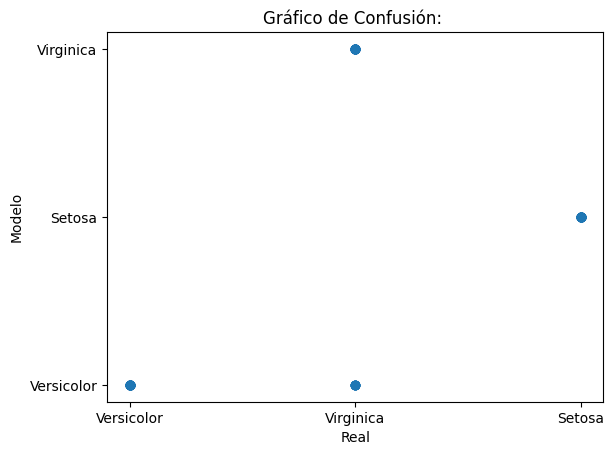

In [59]:
#@title Evaluar red entrenada con datos de entrenamiento

mostrar_detalle_entrenamiento = False #@param {type:"boolean"}

# esta red no usa salida softMax (se mantiene por generlaización de código)
tipo_output_softMax = False

# función auxiliar para el cálculo de error
def calcErrores(pred, real, mostrarDetalle=False):
  arAbs = []
  arRel = []
  
  if mostrarDetalle:
    print("\n")
    print("\t Real \t\t\t Estimado \t\t Error Absoluto \t Error Relativo")

  for pV, r in zip(pred, real):
    # toma el valor estimado/predecido
    p = pV[0]
    # controla que sean números
    if not(math.isnan(r) or math.isnan(p)):
      # hace los cálculos
      eAbs = abs(r - p)
      if r != 0:
        eRel = (eAbs / r)*100.0
      else:
        eRel = (eAbs / 0.00001)*100.0
      arAbs.append(eAbs)
      arRel.append(eRel)
    
      if mostrarDetalle:
        print("\t{:>8.2f} \t\t {:>8.2f} \t\t {:>8.2f} \t\t {:>8.2f}%".format(r, p, eAbs, eRel))

  return arAbs, arRel

def generarGrafico(ar, tit, b=10, c=None):
     # genera gráfico de los errores
    fig = plt.figure(figsize=(15,5)) 
 #   ax = fig.add_axes( [0, 0, 0.8, 0.8] )
 #   ax.boxplot( [arAbs, arRel] )
 #   ax.set_xticklabels( ["Error Absoluto", "Error Relativo"] )
#    plt.legend(["Error Absoluto", "Error Relativo"], loc='best')
    plt.hist( ar, bins=b, color=c )
    plt.grid(color='lightgrey', which='both', axis='both', linestyle='solid', linewidth=0.3)
    plt.title("Distribución de "+ tit)
    plt.show()


# función auxiliar para probar el modelo entrenado en detalle
def probarModelo_Estimacion(x, y, detalle=False):

    # procesa las imágenes de prueba con el modelo 
    estimVals = model.predict(x)

    # llama a la función
    arAbs, arRel = calcErrores(estimVals, y, detalle)

    # muestra métricas
    print("\n")
    print("\n Error Absoluto: ")
    print("            Mínimo: {:.5f} ".format(np.min(arAbs)) )
    print("            Promedio: {:.5f} ± {:.5f}".format(np.mean(arAbs), np.std(arAbs)) )
    print("            Máximo: {:.5f} ".format(np.max(arAbs)) )
    generarGrafico(arAbs, "Error Absoluto", 20, "red")
    
    print("\n Error Relativo: ")
    print("            Mínimo: {:.2f}% ".format(np.min(arRel)) )
    print("            Promedio: {:.2f} ± {:.2f}".format(np.mean(arRel), np.std(arRel)) )
    print("            Máximo: {:.2f}% ".format(np.max(arRel)) )
    generarGrafico(arRel, "Error Relativo", 10, "magenta")


# función auxiliar para probar el modelo entrenado en detalle
def probarModelo_Clasificacion(x, y, clases_map, mostrarDetalle=False):

    # procesa las imágenes de prueba con el modelo 
    predClass = model.predict(x)

    # muestra los resultados con las imágenes 
    umbralClas = 0.5
    classPreds = []
    classReal = []
    for i in range(len(x)):

        # prepara salida
        clReal = clases_map[ y[i] ] 

        # determina la clase predecida
        if tipo_output_softMax:
            ## determina clase predecida de acuerdo a la que tiene mayor valor
            idclPred = int( np.argmax(predClass[i], axis=0) )
            idclPredRnd = idclPred
        else:
            ## determina clase predecida de acuerdo al umbral de clasificación
            idclPred = predClass[i]       
            idclPredRnd = int(idclPred)
            if (idclPred - idclPredRnd)>0.5 and (idclPredRnd+1)<len(clases_map):
                    idclPredRnd = idclPredRnd + 1

        if idclPredRnd<0 or idclPredRnd>=len(clases_map):
            clPred = "CLASE " + str(idclPredRnd) + " INVÁLIDA"
        else:      
            clPred = clases_map[ idclPredRnd ]

        classReal.append( clReal )
        classPreds.append( clPred )

        strTitulo = 'Real: ' + str(clReal) + ' / Modelo(RNA): ' 
        strTitulo = strTitulo + str(clPred) + ' (' + str( idclPred ) +')'   
        strTitulo = strTitulo + ": " + ("ok" if (clPred==clReal) else "error!")

        # muestra comparación con la imagen
        if mostrarDetalle:
          print(strTitulo)

    # muestra reporte de clasificación
    print("\n Reporte de Clasificación: ")
    print(classification_report(classReal, classPreds))

    # muestra matriz de confusion
    print('\nMatriz de Confusión ( real / modelo ): ')
    cm = confusion_matrix(classReal, classPreds, labels=clases_map)
    cmtx = pd.DataFrame(
        cm, 
        index=['r:{:}'.format(x) for x in clases_map], 
        columns=['m:{:}'.format(x) for x in clases_map]
      )
    # agrega para poder mostrar la matrix de confusión completa
    pd.options.display.max_rows = 100
    pd.options.display.max_columns = 100
    cmtx.sort_index(axis=0, inplace=True)
    cmtx.sort_index(axis=1, inplace=True)    
    print(cmtx)
    print("\n")

    # gráfico de comparación
    plt.title('Gráfico de Confusión: ')
    plt.xlabel('Real')
    plt.ylabel('Modelo')
    plt.scatter(classReal, classPreds)

# prueba con los datos de entrenamiento
print("*** Resultados con datos de Entrenamiento: ")
if esProblemaClasificacion:
  probarModelo_Clasificacion(x_train, y_train, CLASES, mostrar_detalle_entrenamiento)
else:
  probarModelo_Estimacion(x_train, y_train, mostrar_detalle_entrenamiento)




*** Resultados con datos de Prueba: 

 Reporte de Clasificación: 
              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        12
  Versicolor       0.81      1.00      0.90        13
   Virginica       1.00      0.77      0.87        13

    accuracy                           0.92        38
   macro avg       0.94      0.92      0.92        38
weighted avg       0.94      0.92      0.92        38


Matriz de Confusión ( real / modelo ): 
              m:Setosa  m:Versicolor  m:Virginica  m:na
r:Setosa            12             0            0     0
r:Versicolor         0            13            0     0
r:Virginica          0             3           10     0
r:na                 0             0            0     0




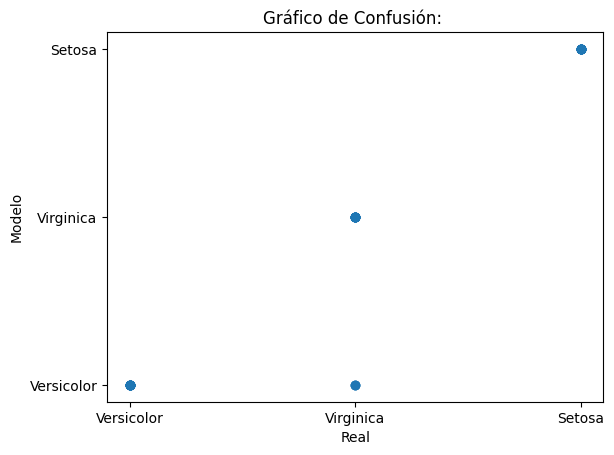

In [60]:
#@title Evaluar red entrenada con datos de prueba
mostrar_detalle_prueba = False #@param {type:"boolean"}

# prueba con los datos de prueba
print("\n\n*** Resultados con datos de Prueba: ")
if esProblemaClasificacion:
  probarModelo_Clasificacion(x_test, y_test, CLASES, mostrar_detalle_prueba)
else:
  probarModelo_Estimacion(x_test, y_test, mostrar_detalle_prueba)


In [61]:
#@title Inspeccionar influencia de los Atributos de Entrada
# fuente: https://scikit-learn.org/stable/modules/permutation_importance.html
determinar_influencia = False #@param {type:"boolean"}

from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer

# define la función para calculo del error
# contando la cantidad de diferencias 
# entre clase real y predecida
def calc_error(realClasses, predClasses):
    res = 0
    for i in range(len(realClasses)):
      res = res + abs(realClasses[i]-predClasses[i])
    return res
errorScorer = make_scorer(calc_error, greater_is_better=False)

def realizarInspeccion(tipoDatos, xScoring, yScoring):
  print("")
  # Genera el scoring usando permutaciones 
  # para realizar el cálculo del scoring
  scoring = {'R2 score':'r2', 
             'Error de Clase':errorScorer}
  r_multi  = permutation_importance(model, xScoring, yScoring,
                              n_repeats=30,
                              random_state=0,
                              scoring=scoring)

  # muesta las métricas
  print("> Cálculo de influencia con datos de " + tipoDatos + ":")
  for metric in r_multi:
    print("- Métrica "+metric+":")
    r = r_multi[metric]
    i = 0
    for imp in r.importances:
        print(f"\tAtributo {i:<2} [ {df.columns[i]} ]:  "
              f"{np.mean(imp):.3f} ± {np.std(imp):.3f}"
              f" [ {np.min(imp):.3f}; {np.max(imp):.3f} ]"
              )
        i = i + 1
  return

if determinar_influencia:
  # Ejecuta con ambos sets de datos
  realizarInspeccion(tipoDatos="Entrenamiento",  
                    xScoring = x_train,
                    yScoring = y_train)

  realizarInspeccion(tipoDatos="Prueba",  
                    xScoring = x_test,
                    yScoring = y_test)

